In [104]:
import sys
sys.path.append('../')
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from pprint import pprint
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.utils import to_categorical
import keras.backend as K
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]
from mlens.visualization import corrmat
from base_learners import cnn,bi_lstm,cnn_bi_lstm,cnn_lstm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [2]:
def load_data_from_file(filename,test_flag = False):
    data = pd.read_csv(filename, sep="\t", header=None)
    if not test_flag:
        data.columns = ["tweet_id", "username", "database_id", "class","tweet"]
    else:
        data.columns = ["a", "b", "med","med", "tweet","class",]
    return data

In [3]:
train_data = load_data_from_file('dataset/personal_intake_tweets.txt')
dev_data = load_data_from_file('dataset/personal_intake_tweets_dev.txt')

In [4]:
train_sentences = train_data['tweet'].tolist()+dev_data['tweet'].tolist()
train_labels = train_data['class'].tolist()+dev_data['class'].tolist()

In [5]:
test_data = load_data_from_file('dataset/task_2_test_full_form.txt',test_flag=True)

In [6]:
test_labels = test_data['class'].tolist()
test_sentences = test_data['tweet'].tolist()

In [7]:
len(train_labels),len(train_sentences),len(test_labels),len(test_sentences)

(9107, 9107, 7419, 7419)

In [8]:
test_labels = [x-1 for x in test_labels]
train_labels = [x-1 for x in train_labels]

In [9]:
number_of_classes = len(set(train_labels))
number_of_classes

3

In [10]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [11]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [12]:
print("cleaning data")
trainX = [clean_sentence(s) for s in train_sentences]
testX = [clean_sentence(s) for s in test_sentences]
trainY = np.array(train_labels)

cleaning data


In [13]:
max_len = 20

In [14]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [16]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [17]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [18]:
def get_results(test_labels,pred_class):
    f1 = f1_score(test_labels,pred_class,labels=[0,1],average='micro')
    p = precision_score(test_labels,pred_class,labels=[0,1],average='micro')
    r = recall_score(test_labels,pred_class,labels=[0,1],average='micro')
    acc = accuracy_score(test_labels,pred_class)
    return [f1,p,r,acc]

In [19]:
def get_pred_class(model):
    pred = model.predict(testX)
    return [int(np.argmax(x)) for x in pred]

In [20]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)
testX = encode_text(tokenizer, testX, max_len)
trainY = to_categorical(trainY,num_classes=number_of_classes)

Max document length: 20
Vocabulary size: 10940


In [58]:
godin_model = load_godin_word_embedding("../word_embeddings/word2vec_twitter_model.bin")

Loading Goding model.


In [59]:
embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)

## Base Learners

In [23]:
model_cnn = load_model('models/cnn.h5')
model_bi_lstm = load_model('models/bi_lstm.h5')
model_cnn_bi_lstm = load_model('models/cnn_bi_lstm.h5')
model_cnn_lstm = load_model('models/cnn_lstm.h5')

In [24]:
base_models = [('cnn',model_cnn),('bi_lstm',model_bi_lstm),('cnn_bi_lstm',model_cnn_bi_lstm),('cnn_lstm',model_cnn_lstm)]

In [25]:
pred_class_base = [(name,get_pred_class(m)) for name,m in base_models]

In [26]:
pred_mat = np.zeros((len(pred_class_base[0][1]),len(pred_class_base)),dtype = np.int64)
for i,p in enumerate(pred_class_base):
    pred_mat[:,i] = p[1]

pred_df = pd.DataFrame(pred_mat)
pred_df.columns = ["cnn", "bi_lstm","cnn_bi_lstm","cnn_lstm"]

In [28]:
result_base = [(name,get_results(test_labels,pred_class)) for name,pred_class in pred_class_base]
result_base_f = []
for t in result_base:
    temp = [t[0]]
    for x in t[1]:
        temp.append(x)
    result_base_f.append(temp)

In [29]:
model_performance = pd.DataFrame(columns=['model','f1', 'precision', 'recall','accuracy'])

In [30]:
for i,result in enumerate(result_base_f):
    model_performance.loc[i] = result

In [31]:
model_performance

,model,f1,precision,recall,accuracy
0,cnn,0.623187,0.587997,0.662857,0.637957
1,bi_lstm,0.617651,0.654555,0.584686,0.662758
2,cnn_bi_lstm,0.632167,0.659142,0.607314,0.672058
3,cnn_lstm,0.637507,0.632135,0.642971,0.669902


## Error prediction Correlation

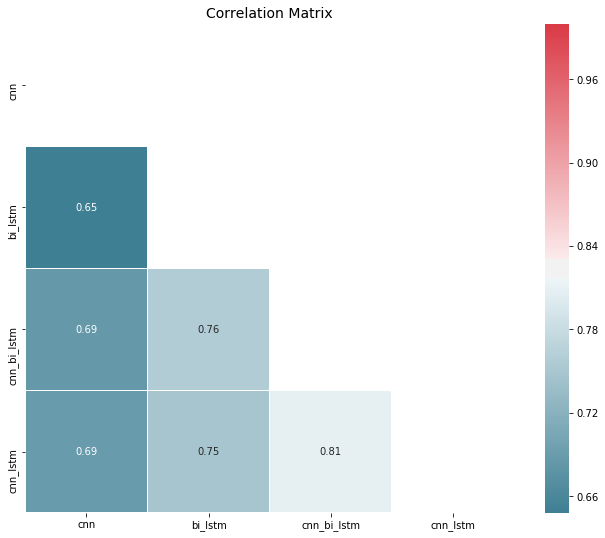

In [32]:
corrmat(pred_df.corr(), inflate=False)

Correlation values are moderately low, there is scope of improvement

## Simple Average

In [33]:
pred_prob_models = np.zeros((len(testX),number_of_classes,len(base_models)))

In [34]:
for i,p in enumerate(base_models):
    pred_prob_models[:,:,i] = p[1].predict(testX)

In [35]:
avg_pred_prob = pred_prob_models.mean(axis=2)

In [36]:
avg_pred_class = [int(np.argmax(x)) for x in avg_pred_prob]

In [37]:
avg_ensemble_result = get_results(test_labels,avg_pred_class)

In [38]:
avg_ensemble_result.insert(0,'avg_ensemble')

In [39]:
model_performance.loc[4] = avg_ensemble_result

In [40]:
model_performance

,model,f1,precision,recall,accuracy
0,cnn,0.623187,0.587997,0.662857,0.637957
1,bi_lstm,0.617651,0.654555,0.584686,0.662758
2,cnn_bi_lstm,0.632167,0.659142,0.607314,0.672058
3,cnn_lstm,0.637507,0.632135,0.642971,0.669902
4,avg_ensemble,0.646064,0.659524,0.633143,0.682572


## Majority Voting 

In [41]:
base_pred_class = np.zeros((len(testX),len(pred_class_base)),dtype = np.int64)

In [42]:
for i,p in enumerate(base_models):
    base_pred_class[:,i] = get_pred_class(p[1])

In [43]:
base_pred_class

array([[2, 2, 2, 2],
       [1, 2, 2, 2],
       [1, 1, 1, 1],
       ...,
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [1, 2, 2, 2]])

In [44]:
majority_pred_class = [int(np.argmax(np.bincount(x))) for x in base_pred_class]

In [45]:
majority_ensemble_result = get_results(test_labels,majority_pred_class)

In [46]:
majority_ensemble_result.insert(0,'majority_ensemble')

In [47]:
model_performance.loc[5] = majority_ensemble_result

In [48]:
model_performance

,model,f1,precision,recall,accuracy
0,cnn,0.623187,0.587997,0.662857,0.637957
1,bi_lstm,0.617651,0.654555,0.584686,0.662758
2,cnn_bi_lstm,0.632167,0.659142,0.607314,0.672058
3,cnn_lstm,0.637507,0.632135,0.642971,0.669902
4,avg_ensemble,0.646064,0.659524,0.633143,0.682572
5,majority_ensemble,0.653894,0.644953,0.663086,0.682437


## Super learner - blending 

In [61]:
seed = 42

In [70]:
parameters_cnn = {
            "n_dense": 100,
            "dropout": 0.7,
            "n_filters": 100,
            "filter_size": 2,
            "em": 'embedding_matrix_godin',
            "batch": 16,
            "epoch": 7
        }


parameters_bi_lstm = {
            "dropout": 0.7,
            "units_out": 128,
            "em": 'embedding_matrix_godin',
            "batch": 8,
            "epoch": 9
        }

parameters_bi_lstm_cnn = {
            "n_filters":400,
            "filter_size":4,
            "em": 'embedding_matrix_godin',
            "conv_dropout":0.7,
            "l_or_g_dropout":0.2,
            "units_out":16,
            "batch": 8,
            "epoch": 12
        }

parameters_lstm_cnn = {
            "n_filters":300,
            "filter_size":2,
            "em": 'embedding_matrix_godin',
            "conv_dropout":0.8,
            "l_or_g_dropout":0.2,
            "units_out":128,
            "batch": 8,
            "epoch": 15
        }

In [71]:
blend_base_cnn = cnn(length=max_len,
                vocab_size=vocab_size,
                n_dense=parameters_cnn['n_dense'],
                dropout=parameters_cnn['dropout'],
                n_filters=parameters_cnn['n_filters'],
                filter_size=int(parameters_cnn['filter_size']),
                em = eval(parameters_cnn['em']),
                number_of_classes=number_of_classes)

blend_base_bi_lstm = bi_lstm(length=max_len,
                        vocab_size=vocab_size,
                        dropout=parameters_bi_lstm['dropout'],
                        units_out=parameters_bi_lstm['units_out'],
                        em=eval(parameters_bi_lstm['em']),
                        number_of_classes=number_of_classes)


blend_base_cnn_bi_lstm = cnn_bi_lstm(length=max_len,
                                vocab_size=vocab_size,
                                n_filters=parameters_bi_lstm_cnn['n_filters'],
                                filter_size=parameters_bi_lstm_cnn['filter_size'],
                                em=eval(parameters_bi_lstm_cnn['em']),
                                number_of_classes=number_of_classes,
                                conv_dropout=parameters_bi_lstm_cnn['conv_dropout'],
                                l_or_g_dropout=parameters_bi_lstm_cnn['l_or_g_dropout'],
                                units_out=parameters_bi_lstm_cnn['units_out'])


blend_base_cnn_lstm = cnn_lstm(length=max_len,
                                vocab_size=vocab_size,
                                n_filters=parameters_bi_lstm_cnn['n_filters'],
                                filter_size=parameters_bi_lstm_cnn['filter_size'],
                                em=eval(parameters_bi_lstm_cnn['em']),
                                number_of_classes=number_of_classes,
                                conv_dropout=parameters_bi_lstm_cnn['conv_dropout'],
                                l_or_g_dropout=parameters_bi_lstm_cnn['l_or_g_dropout'],
                                units_out=parameters_bi_lstm_cnn['units_out'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 400)           4376000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 400)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19, 100)           80100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
__________

In [72]:
blend_base_models = [(parameters_cnn,blend_base_cnn),(parameters_bi_lstm,blend_base_bi_lstm),(parameters_bi_lstm_cnn,blend_base_cnn_bi_lstm),(parameters_lstm_cnn,blend_base_cnn_lstm)]

In [73]:
blend_trainX, blend_testX, blend_trainY, blend_testY = train_test_split(trainX, trainY, test_size=0.10, random_state=seed)

In [74]:
len(blend_trainX),len(blend_trainY),len(blend_testX),len(blend_testY)

(8196, 8196, 911, 911)

In [75]:
metalearner_trainX = np.zeros((len(blend_testX),len(blend_base_models)),dtype=np.int64)

In [76]:
for i,m in enumerate(blend_base_models):
    print(i)
    history = m[1].fit(blend_trainX,blend_trainY,epochs=m[0]["epoch"],batch_size=m[0]["batch"])
    pred = m[1].predict(blend_testX)
    metalearner_trainX[:,i] = [int(np.argmax(x)) for x in pred]

0
Epoch 1/7
8196/8196 [==============================] - 7s 801us/step - loss: 0.5680 - acc: 0.7110
Epoch 2/7
8196/8196 [==============================] - 5s 631us/step - loss: 0.5079 - acc: 0.7524
Epoch 3/7
8196/8196 [==============================] - 5s 612us/step - loss: 0.4845 - acc: 0.7693
Epoch 4/7
8196/8196 [==============================] - 6s 684us/step - loss: 0.4615 - acc: 0.7813
Epoch 5/7
8196/8196 [==============================] - 6s 696us/step - loss: 0.4557 - acc: 0.7875
Epoch 6/7
8196/8196 [==============================] - 6s 697us/step - loss: 0.4399 - acc: 0.7961
Epoch 7/7
8196/8196 [==============================] - 6s 699us/step - loss: 0.4306 - acc: 0.8020
1
Epoch 1/9
8196/8196 [==============================] - 47s 6ms/step - loss: 0.4992 - acc: 0.7594
Epoch 2/9
8196/8196 [==============================] - 45s 5ms/step - loss: 0.4308 - acc: 0.8020
Epoch 3/9
8196/8196 [==============================] - 44s 5ms/step - loss: 0.4073 - acc: 0.8160
Epoch 4/9
8196/8196

In [81]:
blend_meta_model = LogisticRegression()

In [85]:
blend_testY = np.array([int(np.argmax(x)) for x in blend_testY])

In [89]:
blend_meta_model.fit(metalearner_trainX, blend_testY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
test_pred_class = np.zeros((len(testX),len(blend_base_models)),dtype = np.int64)

In [91]:
for i,p in enumerate(base_models):
    test_pred_class[:,i] = get_pred_class(p[1])

In [93]:
blend_ensemble_pred_class = blend_meta_model.predict(test_pred_class)

In [96]:
blend_ensemble_pred_class = list(blend_ensemble_pred_class)

In [98]:
blend_ensemble_result = get_results(test_labels,blend_ensemble_pred_class)

In [99]:
blend_ensemble_result.insert(0,'blend_ensemble')

In [100]:
model_performance.loc[6] = blend_ensemble_result

In [101]:
model_performance

,model,f1,precision,recall,accuracy
0,cnn,0.623187,0.587997,0.662857,0.637957
1,bi_lstm,0.617651,0.654555,0.584686,0.662758
2,cnn_bi_lstm,0.632167,0.659142,0.607314,0.672058
3,cnn_lstm,0.637507,0.632135,0.642971,0.669902
4,avg_ensemble,0.646064,0.659524,0.633143,0.682572
5,majority_ensemble,0.653894,0.644953,0.663086,0.682437
6,blend_ensemble,0.613343,0.677919,0.560000,0.668149


## Super learner - stacked

In [152]:
print("cleaning data")
trainX = np.asarray([clean_sentence(s) for s in train_sentences])
testX = np.asarray([clean_sentence(s) for s in test_sentences])
trainY = np.array(train_labels)

cleaning data


In [153]:
np.random.seed(seed)

In [154]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [155]:
stacked_metalearner_trainX = np.array([[0, 0, 0, 0]],dtype=np.int64)

In [156]:
stacked_metalearner_trainY = []

In [157]:
count=1

In [158]:
for train,test in kfold.split(trainX[:100],trainY[:100]):
    print("----------------------itr = {}--------------".format(count))
    stacked_trainX = list(trainX[train])
    stacked_trainY = list(trainY[train])
    stacked_testX = list(trainX[test])
    stacked_testY = list(trainY[test])
    
    tokenizer = create_tokenizer(stacked_trainX)
    vocab_size = len(tokenizer.word_index) + 1
    stacked_trainX = encode_text(tokenizer, stacked_trainX, max_len)
    stacked_testX = encode_text(tokenizer, stacked_testX, max_len)
    stacked_trainY = to_categorical(stacked_trainY,num_classes=number_of_classes)
    
    embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)
    
    for i in stacked_testY:
        stacked_metalearner_trainY.append(i)
    
    
    base_cnn = cnn(length=max_len,
                vocab_size=vocab_size,
                n_dense=parameters_cnn['n_dense'],
                dropout=parameters_cnn['dropout'],
                n_filters=parameters_cnn['n_filters'],
                filter_size=int(parameters_cnn['filter_size']),
                em = eval(parameters_cnn['em']),
                number_of_classes=number_of_classes)

    base_bi_lstm = bi_lstm(length=max_len,
                            vocab_size=vocab_size,
                            dropout=parameters_bi_lstm['dropout'],
                            units_out=parameters_bi_lstm['units_out'],
                            em=eval(parameters_bi_lstm['em']),
                            number_of_classes=number_of_classes)


    base_cnn_bi_lstm = cnn_bi_lstm(length=max_len,
                                    vocab_size=vocab_size,
                                    n_filters=parameters_bi_lstm_cnn['n_filters'],
                                    filter_size=parameters_bi_lstm_cnn['filter_size'],
                                    em=eval(parameters_bi_lstm_cnn['em']),
                                    number_of_classes=number_of_classes,
                                    conv_dropout=parameters_bi_lstm_cnn['conv_dropout'],
                                    l_or_g_dropout=parameters_bi_lstm_cnn['l_or_g_dropout'],
                                    units_out=parameters_bi_lstm_cnn['units_out'])


    base_cnn_lstm = cnn_lstm(length=max_len,
                                    vocab_size=vocab_size,
                                    n_filters=parameters_bi_lstm_cnn['n_filters'],
                                    filter_size=parameters_bi_lstm_cnn['filter_size'],
                                    em=eval(parameters_bi_lstm_cnn['em']),
                                    number_of_classes=number_of_classes,
                                    conv_dropout=parameters_bi_lstm_cnn['conv_dropout'],
                                    l_or_g_dropout=parameters_bi_lstm_cnn['l_or_g_dropout'],
                                    units_out=parameters_bi_lstm_cnn['units_out'])
    
    stacked_base_models = [(parameters_cnn,base_cnn),(parameters_bi_lstm,base_bi_lstm),(parameters_bi_lstm_cnn,base_cnn_bi_lstm),(parameters_lstm_cnn,base_cnn_lstm)]
    
    
    
    
    temp = np.zeros((len(stacked_testX),len(stacked_base_models)),dtype=np.int64)
    for i,m in enumerate(stacked_base_models):
        print(i)
        history = m[1].fit(stacked_trainX,stacked_trainY,epochs=m[0]["epoch"],batch_size=m[0]["batch"])
        pred = m[1].predict(stacked_testX)
        temp[:,i] = [int(np.argmax(x)) for x in pred]
    stacked_metalearner_trainX = np.concatenate((stacked_metalearner_trainX, temp), axis=0)
    count+=1

----------------------itr = 1--------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 20, 400)           189600    
_________________________________________________________________
dropout_106 (Dropout)        (None, 20, 400)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 19, 100)           80100     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 100)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_107 (Dropout)        (None, 100)               0         
_________________________________________________________________
activation_31 (Activation)   (No

88/88 [==============================] - 0s 4ms/step - loss: 0.5104 - acc: 0.7576
Epoch 8/15
88/88 [==============================] - 0s 4ms/step - loss: 0.4154 - acc: 0.8295
Epoch 9/15
88/88 [==============================] - 0s 4ms/step - loss: 0.3159 - acc: 0.8750
Epoch 10/15
88/88 [==============================] - 0s 4ms/step - loss: 0.2459 - acc: 0.9242
Epoch 11/15
88/88 [==============================] - 0s 4ms/step - loss: 0.1928 - acc: 0.9470
Epoch 12/15
88/88 [==============================] - 0s 4ms/step - loss: 0.1478 - acc: 0.9470
Epoch 13/15
88/88 [==============================] - 0s 4ms/step - loss: 0.1805 - acc: 0.9508
Epoch 14/15
88/88 [==============================] - 0s 4ms/step - loss: 0.0945 - acc: 0.9735
Epoch 15/15
88/88 [==============================] - 0s 4ms/step - loss: 0.1814 - acc: 0.9205
----------------------itr = 2--------------
_________________________________________________________________
Layer (type)                 Output Shape              Par

89/89 [==============================] - 0s 4ms/step - loss: 0.1634 - acc: 0.9738
Epoch 11/12
89/89 [==============================] - 0s 4ms/step - loss: 0.1324 - acc: 0.9775
Epoch 12/12
89/89 [==============================] - 0s 4ms/step - loss: 0.0973 - acc: 0.9813
3
Epoch 1/15
89/89 [==============================] - 9s 98ms/step - loss: 0.6422 - acc: 0.6667
Epoch 2/15
89/89 [==============================] - ETA: 0s - loss: 0.6211 - acc: 0.670 - 0s 6ms/step - loss: 0.6213 - acc: 0.6704
Epoch 3/15
89/89 [==============================] - 1s 7ms/step - loss: 0.6145 - acc: 0.6779
Epoch 4/15
89/89 [==============================] - 1s 9ms/step - loss: 0.6130 - acc: 0.6816
Epoch 5/15
89/89 [==============================] - 1s 7ms/step - loss: 0.5994 - acc: 0.6854
Epoch 6/15
89/89 [==============================] - 0s 5ms/step - loss: 0.5875 - acc: 0.7004
Epoch 7/15
89/89 [==============================] - 1s 6ms/step - loss: 0.5728 - acc: 0.7116
Epoch 8/15
89/89 [====================

89/89 [==============================] - 1s 7ms/step - loss: 0.4669 - acc: 0.7528
2
Epoch 1/12
89/89 [==============================] - 9s 97ms/step - loss: 0.6431 - acc: 0.6629
Epoch 2/12
89/89 [==============================] - 0s 5ms/step - loss: 0.5987 - acc: 0.6742
Epoch 3/12
89/89 [==============================] - 0s 5ms/step - loss: 0.5702 - acc: 0.7154
Epoch 4/12
89/89 [==============================] - 0s 5ms/step - loss: 0.5356 - acc: 0.7303
Epoch 5/12
89/89 [==============================] - 0s 5ms/step - loss: 0.4682 - acc: 0.7865
Epoch 6/12
89/89 [==============================] - 0s 5ms/step - loss: 0.3734 - acc: 0.8464
Epoch 7/12
89/89 [==============================] - 0s 5ms/step - loss: 0.3045 - acc: 0.8839
Epoch 8/12
89/89 [==============================] - 0s 5ms/step - loss: 0.2920 - acc: 0.8727
Epoch 9/12
89/89 [==============================] - 0s 5ms/step - loss: 0.2784 - acc: 0.8876
Epoch 10/12
89/89 [==============================] - 0s 5ms/step - loss: 0.177

90/90 [==============================] - 0s 1ms/step - loss: 0.6290 - acc: 0.6667
1
Epoch 1/9
90/90 [==============================] - 9s 101ms/step - loss: 0.6250 - acc: 0.6667
Epoch 2/9
90/90 [==============================] - 1s 7ms/step - loss: 0.6082 - acc: 0.6778
Epoch 3/9
90/90 [==============================] - 1s 8ms/step - loss: 0.6035 - acc: 0.6926
Epoch 4/9
90/90 [==============================] - 1s 8ms/step - loss: 0.5778 - acc: 0.7259
Epoch 5/9
90/90 [==============================] - 1s 7ms/step - loss: 0.5252 - acc: 0.7333
Epoch 6/9
90/90 [==============================] - 1s 9ms/step - loss: 0.4865 - acc: 0.7667
Epoch 7/9
90/90 [==============================] - 1s 8ms/step - loss: 0.4015 - acc: 0.8222
Epoch 8/9
90/90 [==============================] - 1s 8ms/step - loss: 0.3522 - acc: 0.8222
Epoch 9/9
90/90 [==============================] - 1s 8ms/step - loss: 0.4087 - acc: 0.8074
2
Epoch 1/12
90/90 [==============================] - 9s 95ms/step - loss: 0.6424 - ac

Epoch 1/7
90/90 [==============================] - 9s 96ms/step - loss: 0.6383 - acc: 0.6407
Epoch 2/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6436 - acc: 0.6481
Epoch 3/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6157 - acc: 0.6556
Epoch 4/7
90/90 [==============================] - 0s 985us/step - loss: 0.6243 - acc: 0.6556
Epoch 5/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6371 - acc: 0.6481
Epoch 6/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6320 - acc: 0.6704
Epoch 7/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6339 - acc: 0.6593
1
Epoch 1/9
90/90 [==============================] - 9s 99ms/step - loss: 0.6358 - acc: 0.6667
Epoch 2/9
90/90 [==============================] - 1s 8ms/step - loss: 0.6056 - acc: 0.6778
Epoch 3/9
90/90 [==============================] - 1s 7ms/step - loss: 0.5981 - acc: 0.6926
Epoch 4/9
90/90 [==============================] - 1s 8ms/step - loss: 0.5

Epoch 1/7
90/90 [==============================] - 8s 93ms/step - loss: 0.6331 - acc: 0.6556
Epoch 2/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6379 - acc: 0.6593
Epoch 3/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6275 - acc: 0.6593
Epoch 4/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6172 - acc: 0.6741
Epoch 5/7
90/90 [==============================] - 0s 1ms/step - loss: 0.6152 - acc: 0.6741
Epoch 6/7
90/90 [==============================] - 0s 990us/step - loss: 0.6222 - acc: 0.6630
Epoch 7/7
90/90 [==============================] - 0s 966us/step - loss: 0.6024 - acc: 0.6815
1
Epoch 1/9
90/90 [==============================] - 9s 104ms/step - loss: 0.6304 - acc: 0.6667
Epoch 2/9
90/90 [==============================] - 1s 7ms/step - loss: 0.6198 - acc: 0.6667
Epoch 3/9
90/90 [==============================] - 1s 7ms/step - loss: 0.5986 - acc: 0.6926
Epoch 4/9
90/90 [==============================] - 1s 8ms/step - loss: 

Epoch 1/7
91/91 [==============================] - 11s 119ms/step - loss: 0.6128 - acc: 0.6703
Epoch 2/7
91/91 [==============================] - 0s 897us/step - loss: 0.6306 - acc: 0.6557
Epoch 3/7
91/91 [==============================] - 0s 774us/step - loss: 0.5971 - acc: 0.6777
Epoch 4/7
91/91 [==============================] - 0s 895us/step - loss: 0.6039 - acc: 0.6850
Epoch 5/7
91/91 [==============================] - 0s 916us/step - loss: 0.6209 - acc: 0.6740
Epoch 6/7
91/91 [==============================] - 0s 775us/step - loss: 0.6230 - acc: 0.6667
Epoch 7/7
91/91 [==============================] - 0s 755us/step - loss: 0.6173 - acc: 0.6777
1
Epoch 1/9
91/91 [==============================] - 13s 138ms/step - loss: 0.6279 - acc: 0.6667
Epoch 2/9
91/91 [==============================] - 1s 8ms/step - loss: 0.6051 - acc: 0.6923
Epoch 3/9
91/91 [==============================] - 1s 8ms/step - loss: 0.6037 - acc: 0.6886
Epoch 4/9
91/91 [==============================] - 1s 7ms/st

Epoch 1/7
91/91 [==============================] - 11s 124ms/step - loss: 0.6528 - acc: 0.6557
Epoch 2/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6156 - acc: 0.6777
Epoch 3/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6243 - acc: 0.6484
Epoch 4/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6140 - acc: 0.6557
Epoch 5/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6048 - acc: 0.6923
Epoch 6/7
91/91 [==============================] - 0s 2ms/step - loss: 0.6175 - acc: 0.6740
Epoch 7/7
91/91 [==============================] - 0s 2ms/step - loss: 0.6085 - acc: 0.6667
1
Epoch 1/9
91/91 [==============================] - 12s 130ms/step - loss: 0.6330 - acc: 0.6667
Epoch 2/9
91/91 [==============================] - 1s 9ms/step - loss: 0.6116 - acc: 0.6740
Epoch 3/9
91/91 [==============================] - 1s 13ms/step - loss: 0.6038 - acc: 0.6777
Epoch 4/9
91/91 [==============================] - 1s 12ms/step - loss:

Epoch 1/7
91/91 [==============================] - 11s 123ms/step - loss: 0.6533 - acc: 0.6593
Epoch 2/7
91/91 [==============================] - 0s 708us/step - loss: 0.6305 - acc: 0.6667
Epoch 3/7
91/91 [==============================] - 0s 741us/step - loss: 0.6249 - acc: 0.6557
Epoch 4/7
91/91 [==============================] - 0s 744us/step - loss: 0.6190 - acc: 0.6520
Epoch 5/7
91/91 [==============================] - 0s 762us/step - loss: 0.6280 - acc: 0.6447
Epoch 6/7
91/91 [==============================] - 0s 796us/step - loss: 0.6243 - acc: 0.6667
Epoch 7/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6140 - acc: 0.6923
1
Epoch 1/9
91/91 [==============================] - 14s 159ms/step - loss: 0.6337 - acc: 0.6667
Epoch 2/9
91/91 [==============================] - 1s 6ms/step - loss: 0.6127 - acc: 0.6667
Epoch 3/9
91/91 [==============================] - 1s 6ms/step - loss: 0.6001 - acc: 0.6777
Epoch 4/9
91/91 [==============================] - 1s 6ms/step

Epoch 1/7
91/91 [==============================] - 13s 139ms/step - loss: 0.6483 - acc: 0.6557
Epoch 2/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6418 - acc: 0.6667
Epoch 3/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6246 - acc: 0.6813
Epoch 4/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6105 - acc: 0.6630
Epoch 5/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6301 - acc: 0.6374
Epoch 6/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6189 - acc: 0.6630
Epoch 7/7
91/91 [==============================] - 0s 1ms/step - loss: 0.6120 - acc: 0.6630
1
Epoch 1/9
91/91 [==============================] - 13s 148ms/step - loss: 0.6330 - acc: 0.6667
Epoch 2/9
91/91 [==============================] - 1s 7ms/step - loss: 0.6063 - acc: 0.6886
Epoch 3/9
91/91 [==============================] - 1s 7ms/step - loss: 0.6049 - acc: 0.6703
Epoch 4/9
91/91 [==============================] - 1s 7ms/step - loss: 0

In [165]:
len(stacked_metalearner_trainY)

100

In [ ]:
sta